In [5]:
import numpy as np
import torch
from livelossplot import PlotLosses
from torchsummary import summary
from sklearn.metrics import mean_squared_error
import torch 
import os
import matplotlib.pyplot as plt

# import custom packages
from WildfireGenerate.models import VAE
from WildfireGenerate.task2functions import training, predict


In [6]:
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

#### Load training and test data

In [7]:
data_path =  'data/Ferguson_fire_train.npy'
train_data = np.load(data_path)
test_path =  'data/Ferguson_fire_test.npy'
test_data = np.load(test_path)

## 1. Training

#### Create data loaders

In [8]:
split_size = 5
batch_size = 16
seq_length = 100

train_loader, train_shifted_loader, test_loader, test_shifted_loader = training.create_dataloaders(train_data, test_data, seq_length, split_size, batch_size)

# Check dataset shapes and lengths
print(f'Train dataset shape: {train_loader.dataset.shape}')
print(f'Test dataset shape: {test_loader.dataset.shape}')

del train_data, test_data

Train dataset shape: torch.Size([125, 19, 256, 256])
Test dataset shape: torch.Size([50, 19, 256, 256])


#### Define model

In [9]:
torch.cuda.empty_cache()
channel_size = 100//split_size -1
latent_dim = 64
image_size = 256
print(channel_size)
model = VAE(latent_dim = latent_dim, 
                channel_size = channel_size
                ).to(device)

summary(model, (1, 19, 256, 256))

19


: 

The model data/Final_Linear.pth was already trained.


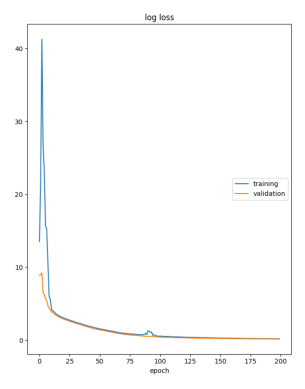

In [ ]:
model_name = 'data/Final_Linear.pth'

if os.path.exists(model_name):
    print(f"The model {model_name} was already trained.")
    plot_filename = 'data/Task2LogLoss.png'

    # Load the model
    model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
    # model = model_info['model']

    # Plot loss plot
    loss_plot_image = plt.imread(plot_filename)
    plt.imshow(loss_plot_image)
    plt.axis('off')  # Turn off axis
    plt.show()
    
else:
    print("Training new model.")
    num_epochs = 20
    liveloss = PlotLosses()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        logs = {}
        train_loss = train.train(model, train_loader, train_shifted_loader)
        logs['log loss'] = train_loss.detach().numpy()

        val_loss = train.validate(model, test_loader, test_shifted_loader)
        logs['val_log loss'] = val_loss.detach().numpy()

        liveloss.update(logs)
        liveloss.draw()

    plot_filename = 'data/Task2LogLoss.png'
    

    torch.save(model_name)

## 2. Prediction

### Extract random sample from latent space

In [ ]:
predicted_samples = predict.predict_samples(model, 2, latent_dim)
print(predicted_samples[0].shape)
print(predicted_samples[1].shape)


(19, 256, 256)
(19, 256, 256)


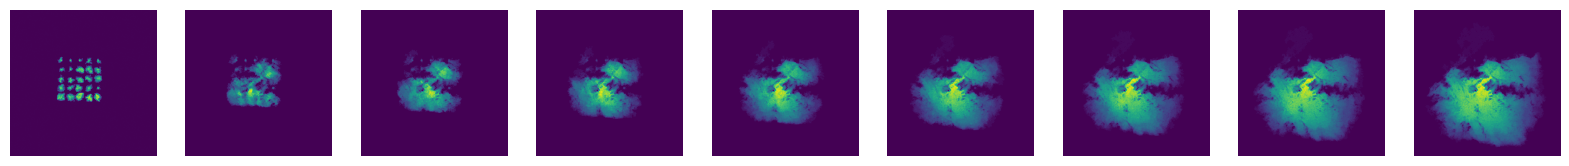

In [ ]:
predict.display_samples(predicted_samples, channel_size)

## 3. MSE with Satellite Observed Data

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
obs_dataset = np.load('data/Ferguson_fire_obs.npy')

In [ ]:
obs_dataset.shape

(5, 256, 256)

See the notebook `Chosing_Image.ipynb`. In that notebook we built a metric to chose the best AI generated images for each of the satellite and background images. 

Here we are going to pick those best 5 images and calculate the MSE with the satellite data:

In [ ]:
best_generated_images = np.load('WildfirePredict/chosing_images/final_image.npy')

In [ ]:
best_generated_images.shape

(5, 1, 256, 256)

In [ ]:
best_generated_images = best_generated_images.reshape(5,256,256)

In [ ]:
best_generated_images.shape

(5, 256, 256)

In [ ]:
mean_squared_error(obs_dataset, best_generated_images)

0.07460819912002872

After comparing the satellite images with our AI-generated images, we achieved a Mean Squared Error (MSE) of 0.0746. This low MSE value indicates a strong alignment between the satellite images and the images produced by our model. Essentially, the model's ability to predict the state of the system 5 time steps ahead is quite accurate, as demonstrated by the minimal error in the generated images compared to the actual satellite data. This level of precision suggests that our model effectively captures the underlying patterns and dynamics observed in the satellite imagery, thereby validating the model's performance and its suitability for data assimilation purposes.